<a href="https://colab.research.google.com/github/perfectism13/learning_colab/blob/master/MFFs_model/mffs_model_dropout_more.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')
import os
# os.chdir(r'/content/drive/My Drive/colab/mlnd_distracted_driver_detection/state-farm-distracted-driver-detection/imgs/')
os.chdir(r'/content/drive/My Drive/state-farm-distracted-driver-detection/imgs/')
# os.chdir(r'/content/drive/My Drive/data/imgs/')
print(os.getcwd())
!ls
!pip install keras==2.1.5
import keras
print(keras.__version__)
!nvidia-smi

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive/state-farm-distracted-driver-detection/imgs
'(1-726)clean.mp4'
'(1-726).mp4'
 5-0.15993-0.15993.zip
'（726-800)clean.mp4'
 （726-800）.mp4
'(726-966)clean.mp4'
'(726-966).mp4'
 C3D_rgbs_model_backup.h5
 C3D_Sport1M_weights_keras_2.2.4.h5
 driver_imgs_list_class_2.csv
 driver_imgs_list_class.csv
 driver_imgs_list.csv
 driver_imgs_list_right.csv
 flow_xception_lock50.h5
 flow_xception_lock70.h5
 get-docker.sh
 I3D_rgbs_model.h5
 mffs_model_n

Using TensorFlow backend.


2.1.5
Fri Feb 14 09:14:25 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.48.02    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
| 

In [0]:
import os
os.environ['KERAS_BACKEND']='tensorflow'
import keras

In [0]:
import numpy as np
np.random.seed(2017)

import os
import glob
import cv2
import math
import pickle
import pandas as pd
import random
from tqdm import tqdm
from matplotlib import pyplot as plt

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.optimizers import SGD, Adam, Nadam
from keras.utils import np_utils
from keras.models import model_from_json
from sklearn.metrics import log_loss

### 切分数据
按照司机的id来切分训练数据集。把driver_imgs_list分成两个列表。一个是训练列表，里面是所有训练集司机的图片文件名。另一个是验证列表，里面是所有验证集司机的图片文件名。然后把两个列表都随机打乱。 这里列表里面保存的都只是excel文件里的一行行数据（包括文件名，分类，司机id），而不是图片本身。等训练时通过生成器读取图片，这样节约内存。 另外还保存了一个类别字典，便于以后从同一类中抽取图片进行拼接。

In [4]:
# divide drivers
# unique_list_train = ['p002', 'p012', 'p014', 'p015', 'p026', 'p035', 'p039', 'p041', 'p042', 'p045', 'p047', 'p049', 'p050', 'p051', 'p052', 'p056', 'p061', 'p064', 'p066', 'p072', 'p075']
# unique_list_valid = ['p016', 'p021', 'p022', 'p024']
unique_list_train = ['p024', 'p026', 'p035', 'p039', 'p041', 'p042', 'p045', 'p047', 'p049', 'p050', 'p051', 'p052', 'p056', 'p061', 'p064', 'p066', 'p072', 'p075']
unique_list_valid = ['p002', 'p012', 'p014', 'p015','p016', 'p021', 'p022']
#print (unique_list_train, unique_list_valid)

# get index: driver_id, class, image name
index = os.path.join('.', 'driver_imgs_list_class_2.csv')

# build the driver id dictionary and class dictionary
f = open(index, 'r')
id_dict = dict()
class_dict = dict()
lines = f.readlines()


# split the train list and valid list by id
train_list = []
valid_list = []

for line in lines[1:]:
    arr = line.strip().split(',')
    if arr[0]  in unique_list_train:
        train_list.append(line)
    elif arr[0]  in unique_list_valid:
      valid_list.append(line)
f.close()

random.shuffle(train_list)
random.shuffle(valid_list)

print (len(train_list), len(valid_list))

14754 6847


### 获取test set图片的列表
获取sample_submission.csv中所有测试图片的文件名，预测test set时使用。

In [0]:
test_index = os.path.join('.', 'sample_submission.csv')
f = open(test_index, 'r')
lines = f.readlines()
test_list = []
for line in lines[1:]:
    arr = line.strip().split(',')
    test_list.append(arr[0])
f.close()
print (test_list[:5])

['img_1.jpg', 'img_10.jpg', 'img_100.jpg', 'img_1000.jpg', 'img_100000.jpg']


### 转换为One Hot Encode标签

对分类标签进行One Hot Encode的函数如下。

In [5]:
# one hot encode the class label

from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
lb.fit(['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9'])   
def one_hot_encode(x):
    return lb.transform(x)
t = one_hot_encode(['c1', 'c2'])
print(t)

[[0 1 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0]]


###获取两帧图片之间的光流

In [0]:
# -*- coding: utf-8 -*-
import cv2
import numpy as np
from keras.preprocessing import image
from random import choice
# image rotation
def rotate(x1,x2, degree, row_axis=0, col_axis=1, channel_axis=2, fill_mode='wrap', cval=0.):
    theta = np.pi / 180 * degree
    rotation_matrix = np.array([[np.cos(theta), -np.sin(theta), 0],
    [np.sin(theta), np.cos(theta), 0],
    [0, 0, 1]])
    h, w = x1.shape[row_axis], x1.shape[col_axis]
    transform_matrix = image.transform_matrix_offset_center(rotation_matrix, h, w)
    x1 = image.apply_transform(x1, transform_matrix, channel_axis, fill_mode, cval)
    x2 = image.apply_transform(x2, transform_matrix, channel_axis, fill_mode, cval)
    return x1,x2

# image shift
def shift(x1,x2, wshift, hshift, row_axis=0, col_axis=1, channel_axis=2, fill_mode='wrap', cval=0.):
    h, w = x1.shape[row_axis], x1.shape[col_axis] #读取图片的高和宽
    tx = hshift * h #高偏移大小，若不偏移可设为0，若向上偏移设为正数
    ty = wshift * w #宽偏移大小，若不偏移可设为0，若向左偏移设为正数
    translation_matrix = np.array([[1, 0, tx],
                                  [0, 1, ty],
                                  [0, 0, 1]])
    transform_matrix = translation_matrix  
    x1 = image.apply_transform(x1, transform_matrix, channel_axis, fill_mode, cval)
    x2 = image.apply_transform(x1, transform_matrix, channel_axis, fill_mode, cval)
    return x1,x2

#左右或者上下翻转
def flip(frame1,frame2,tar):
  frame1 = cv2.flip(frame1,tar)
  frame2 = cv2.flip(frame2,tar)
  return frame1,frame2
#水平翻转90°
def transpose(frame1,frame2,tar):
  if(tar==1):
      frame1 = cv2.transpose(frame1)
      frame2 = cv2.transpose(frame2)
  return frame1,frame2

def get_mffs_aug(path1,path2):
  frame1 = cv2.imread(path1)
  frame1 = cv2.resize(frame1, (299, 299))
  prvs = cv2.cvtColor(frame1,cv2.COLOR_BGR2GRAY)
  hsv = np.zeros_like(frame1)
  hsv[...,1] = 255
  frame2 = cv2.imread(path2)
  frame2 = cv2.resize(frame2, (299, 299))
  #random rotate
  deg = random.uniform(-10, 10) #random rotate limit
  frame1,frame2 = rotate(frame1,frame2, deg)
  #random shift
  wshift = random.uniform(-0.1, 0.1)
  hshift = random.uniform(-0.1, 0.1)
  frame1,frame2 = shift(frame1,frame2, wshift, hshift)
  #random flip
  foo = [0,-1,1]
  tar = choice(foo)
  frame1,frame2 = flip(frame1,frame2,tar)
  #水平翻转90°
  #random transpose
  foo = [0,1]
  tar = choice(foo)
  frame1,frame2 = transpose(frame1,frame2,tar)
  next = cv2.cvtColor(frame2,cv2.COLOR_BGR2GRAY)
  flow = cv2.calcOpticalFlowFarneback(prvs,next, None, 0.5, 3, 15, 3, 5, 1.2, 0)
  mag, ang = cv2.cartToPolar(flow[...,0], flow[...,1])
  hsv[...,0] = ang*180/np.pi/2
  hsv[...,2] = cv2.normalize(mag,None,0,255,cv2.NORM_MINMAX)
  rgb = cv2.cvtColor(hsv,cv2.COLOR_HSV2BGR)
  frame1 = cv2.cvtColor(frame1, cv2.COLOR_BGR2RGB)
  data = np.zeros((299, 299,5))
  data[:, :, 0] = frame1[:, :, 0]
  data[:, :, 1] = frame1[:, :, 1]
  data[:, :, 2] = frame1[:, :, 2]
  data[:, :, 3] = hsv[:, :, 0]
  data[:, :, 4] = hsv[:, :, 2]
  # normalization
  data = np.array(data, dtype=np.float32)  
  data /= 127.5
  data -= 1.
  return data

def get_mffs(path1,path2):
  frame1 = cv2.imread(path1)
  frame1 = cv2.resize(frame1, (299, 299))
  prvs = cv2.cvtColor(frame1,cv2.COLOR_BGR2GRAY)
  hsv = np.zeros_like(frame1)
  hsv[...,1] = 255
  frame2 = cv2.imread(path2)
  frame2 = cv2.resize(frame2, (299, 299))
  next = cv2.cvtColor(frame2,cv2.COLOR_BGR2GRAY)
  flow = cv2.calcOpticalFlowFarneback(prvs,next, None, 0.5, 3, 15, 3, 5, 1.2, 0)
  mag, ang = cv2.cartToPolar(flow[...,0], flow[...,1])
  hsv[...,0] = ang*180/np.pi/2
  hsv[...,2] = cv2.normalize(mag,None,0,255,cv2.NORM_MINMAX)
  rgb = cv2.cvtColor(hsv,cv2.COLOR_HSV2BGR)
  frame1 = cv2.cvtColor(frame1, cv2.COLOR_BGR2RGB)
  data = np.zeros((299, 299,5))
  data[:, :, 0] = frame1[:, :, 0]
  data[:, :, 1] = frame1[:, :, 1]
  data[:, :, 2] = frame1[:, :, 2]
  data[:, :, 3] = hsv[:, :, 0]
  data[:, :, 4] = hsv[:, :, 2]
  # normalization
  data = np.array(data, dtype=np.float32)  
  data /= 127.5
  data -= 1.
  return data


###获取光流2

In [0]:
# -*- coding: utf-8 -*-
import cv2
import numpy as np
from keras.preprocessing import image
from random import choice
# image rotation
def rotate(x1,x2, degree, row_axis=0, col_axis=1, channel_axis=2, fill_mode='wrap', cval=0.):
    theta = np.pi / 180 * degree
    rotation_matrix = np.array([[np.cos(theta), -np.sin(theta), 0],
    [np.sin(theta), np.cos(theta), 0],
    [0, 0, 1]])
    h, w = x1.shape[row_axis], x1.shape[col_axis]
    transform_matrix = image.transform_matrix_offset_center(rotation_matrix, h, w)
    x1 = image.apply_transform(x1, transform_matrix, channel_axis, fill_mode, cval)
    x2 = image.apply_transform(x2, transform_matrix, channel_axis, fill_mode, cval)
    return x1,x2

# image shift
def shift(x1,x2, wshift, hshift, row_axis=0, col_axis=1, channel_axis=2, fill_mode='wrap', cval=0.):
    h, w = x1.shape[row_axis], x1.shape[col_axis] #读取图片的高和宽
    tx = hshift * h #高偏移大小，若不偏移可设为0，若向上偏移设为正数
    ty = wshift * w #宽偏移大小，若不偏移可设为0，若向左偏移设为正数
    translation_matrix = np.array([[1, 0, tx],
                                  [0, 1, ty],
                                  [0, 0, 1]])
    transform_matrix = translation_matrix  
    x1 = image.apply_transform(x1, transform_matrix, channel_axis, fill_mode, cval)
    x2 = image.apply_transform(x1, transform_matrix, channel_axis, fill_mode, cval)
    return x1,x2

#左右或者上下翻转
def flip(frame1,frame2,tar):
  frame1 = cv2.flip(frame1,tar)
  frame2 = cv2.flip(frame2,tar)
  return frame1,frame2
#水平翻转90°
def transpose(frame1,frame2,tar):
  if(tar==1):
      frame1 = cv2.transpose(frame1)
      frame2 = cv2.transpose(frame2)
  return frame1,frame2

def get_mffs_aug(path1,path2):
  frame1 = cv2.imread(path1)
  frame1 = cv2.resize(frame1, (299, 299))
  prvs = cv2.cvtColor(frame1,cv2.COLOR_BGR2GRAY)
  hsv = np.zeros_like(frame1)
  hsv[...,1] = 255
  frame2 = cv2.imread(path2)
  frame2 = cv2.resize(frame2, (299, 299))
  #random rotate
  deg = random.uniform(-10, 10) #random rotate limit
  frame1,frame2 = rotate(frame1,frame2, deg)
  #random shift
  wshift = random.uniform(-0.1, 0.1)
  hshift = random.uniform(-0.1, 0.1)
  frame1,frame2 = shift(frame1,frame2, wshift, hshift)
  #random flip
  foo = [0,-1,1]
  tar = choice(foo)
  frame1,frame2 = flip(frame1,frame2,tar)
  #水平翻转90°
  #random transpose
  foo = [0,1]
  tar = choice(foo)
  frame1,frame2 = transpose(frame1,frame2,tar)
  next = cv2.cvtColor(frame2,cv2.COLOR_BGR2GRAY)
  flow = cv2.calcOpticalFlowFarneback(prvs,next, None, 0.5, 3, 15, 3, 5, 1.2, 0)
  # mag, ang = cv2.cartToPolar(flow[...,0], flow[...,1])
  # hsv[...,0] = ang*180/np.pi/2
  # hsv[...,2] = cv2.normalize(mag,None,0,255,cv2.NORM_MINMAX)
  hsv[...,0] = cv2.normalize(flow[...,0],None,0,255,cv2.NORM_MINMAX)
  hsv[...,2] = cv2.normalize(flow[...,1],None,0,255,cv2.NORM_MINMAX)
  # rgb = cv2.cvtColor(hsv,cv2.COLOR_HSV2BGR)
  frame1 = cv2.cvtColor(frame1, cv2.COLOR_BGR2RGB)
  data = np.zeros((299, 299,5))
  data[:, :, 0] = frame1[:, :, 0]
  data[:, :, 1] = frame1[:, :, 1]
  data[:, :, 2] = frame1[:, :, 2]
  data[:, :, 3] = hsv[:, :, 0]
  data[:, :, 4] = hsv[:, :, 2]
  # normalization
  data = np.array(data, dtype=np.float32)  
  data /= 127.5
  data -= 1.
  return data

def get_mffs(path1,path2):
  frame1 = cv2.imread(path1)
  frame1 = cv2.resize(frame1, (299, 299))
  prvs = cv2.cvtColor(frame1,cv2.COLOR_BGR2GRAY)
  hsv = np.zeros_like(frame1)
  hsv[...,1] = 255
  frame2 = cv2.imread(path2)
  frame2 = cv2.resize(frame2, (299, 299))
  next = cv2.cvtColor(frame2,cv2.COLOR_BGR2GRAY)
  flow = cv2.calcOpticalFlowFarneback(prvs,next, None, 0.5, 3, 15, 3, 5, 1.2, 0)
  # mag, ang = cv2.cartToPolar(flow[...,0], flow[...,1])
  # hsv[...,0] = ang*180/np.pi/2
  # hsv[...,2] = cv2.normalize(mag,None,0,255,cv2.NORM_MINMAX)
  hsv[...,0] = cv2.normalize(flow[...,0],None,0,255,cv2.NORM_MINMAX)
  hsv[...,2] = cv2.normalize(flow[...,1],None,0,255,cv2.NORM_MINMAX)
  # rgb = cv2.cvtColor(hsv,cv2.COLOR_HSV2BGR)
  frame1 = cv2.cvtColor(frame1, cv2.COLOR_BGR2RGB)
  data = np.zeros((299, 299,5))
  data[:, :, 0] = frame1[:, :, 0]
  data[:, :, 1] = frame1[:, :, 1]
  data[:, :, 2] = frame1[:, :, 2]
  data[:, :, 3] = hsv[:, :, 0]
  data[:, :, 4] = hsv[:, :, 2]
  # normalization
  data = np.array(data, dtype=np.float32)  
  data /= 127.5
  data -= 1.
  return data


### 训练图片生成器

从训练列表中遍历。yield一个batch的训练图片及其标签。图片经过了实时增强。另外还有50%的概率随机选取另一张同类里的图片，将两张的左右各半边拼接在一起。这也是为了训练模型对分类的关键部位进行学习，而不是记住司机的样子

In [0]:
# define my train data generator

def train_gen(batch_size):
    #random.shuffle(train_list) # 每一代都随机shuffle训练集
    current = 0
    while 1:
        x = []
        y = []
        while len(y) < batch_size:
            line = train_list[current]
            arr = line.strip().split(',')
            path1 = os.path.join('.', 'train', str(arr[1]), str(arr[2]))
            path3 = os.path.join('.', 'train', str(arr[4]), str(arr[5]))
            # img = get_im_cv2_aug(path1, 299)
            # img3 = get_im_cv2_aug(path3, 299)
            mffs = get_mffs_aug(path1,path3)
            # if random.random()>0.5:
            #     line2 = random.choice(class_dict[arr[1]])
            #     bname = line2.strip().split(',')[2]
            #     path2 = os.path.join('.', 'train', str(arr[1]), str(bname))
            #     img2 = get_im_cv2_aug(path2, 299)
            #     left = img[:, :150, :]
            #     right = img2[:, 150:, :]
            #     img = np.concatenate((left, right), axis=1)
            x.append(mffs)
            label = one_hot_encode([str(arr[1])])[0]
            y.append(label)
            current += 1
            if current >= len(train_list):
                current = 0
        x = np.array(x)
        img_size = 299
        x = x.reshape(batch_size, img_size, img_size, 5) 
        y = np.array(y, dtype = np.uint8)
        y = y.reshape(batch_size, 10)
        yield (x, y)

### 验证图片生成器

从验证列表中遍历。yield一个batch的验证图片及其标签。为了体现模型训练后的拟合能力，图片没有进行实时增强。

In [0]:
# define my validation data generator

def valid_gen(batch_size):
    current = 0
    while 1:
        x = []
        y = []
        while len(y) < batch_size:
            line = valid_list[current]
            arr = line.strip().split(',')
            path1 = os.path.join('.', 'train', str(arr[1]), str(arr[2]))
            path3 = os.path.join('.', 'train', str(arr[4]), str(arr[5]))
            #print (path)
            mffs = get_mffs(path1,path3)
            x.append(mffs)
            label = one_hot_encode([str(arr[1])])[0]
            y.append(label)
            current += 1
            if current >= len(valid_list):
                current = 0
        x = np.array(x)
        img_size = 299
        x = x.reshape(batch_size, img_size, img_size, 5) 
        y = np.array(y, dtype = np.uint8)
        y = y.reshape(batch_size, 10)
        yield (x, y)

###验证数据类型

In [0]:
current = 0
path = []
num_frames=16
print(train_list[0])
line=train_list[current]
arr=line.strip().split(',')
path1=os.path.join('.', 'train', str(arr[1]), str(arr[2]))
print(path1)
path2=os.path.join('.', 'train', str(arr[4]), str(arr[5]))

mffs_aug = get_mffs_aug(path1,path2)
mffs = get_mffs(path1,path2)
print(mffs_aug.shape)
print(mffs.shape)


p061,c5,img_80030.jpg,p061,c5,img_5941.jpg

./train/c5/img_80030.jpg
(299, 299, 5)
(299, 299, 5)


### 构建模型

用keras构建模型。使用在ImageNet上预训练好的Xception模型，接上一个global average pooling层，dropout防止过拟合，最后一个全连接层输出10个类别的概率。在全连接层的权重上采用了L2正则化。锁定模型的前70层不更新权重.

In [0]:
from keras import backend as K
K.clear_session()

In [0]:
# new model

from keras.models import *
from keras.layers import *
from keras.applications import *
from keras.preprocessing.image import *

# img_size = 297
# x = Input((img_size, img_size, 3))
# base_model1 = Xception(input_tensor = x, weights='imagenet', include_top=False)
# base_model2 = Model(x,base_model1.output)
y = Input((299, 299, 5))
# y = Conv2D(3,(3,3), strides=(1, 1))(y)
# y = BatchNormalization()(y)
# m = Activation('relu')(y)
base_model = Xception(input_tensor = y, weights='imagenet', include_top=False)
m = GlobalAveragePooling2D()(base_model.output)
m = Dropout(0.5)(m)
m = Dense(10, activation='softmax', kernel_regularizer=regularizers.l2(0.01))(m)
model = Model(base_model.input,m)
# for i in range(70):
#     model.layers[i].trainable = False
model.summary()
len(model.layers)











83689472/83683744 [==============================] - 2s 0us/step


ValueError: ignored

###构建视频预测模型

In [0]:
from keras.models import Model
from keras import layers
from keras.layers import Dense, Input, BatchNormalization, Activation
from keras.layers import Conv2D, SeparableConv2D, MaxPooling2D, GlobalAveragePooling2D, GlobalMaxPooling2D, Dropout
from keras.applications.imagenet_utils import _obtain_input_shape
from keras.utils.data_utils import get_file

# from keras.models import *
# from keras.layers import *
# from keras.applications import *
# from keras.preprocessing.image import *
from keras import regularizers

WEIGHTS_PATH = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.4/xception_weights_tf_dim_ordering_tf_kernels_notop.h5'

def Xception():

	# Determine proper input shape
	# input_shape = _obtain_input_shape(None, default_size=299, min_size=71, data_format='channels_last', include_top=False)
  img_size =299
  img_input = Input((img_size, img_size, 5))
	# img_input = Input(shape=input_shape)
  # x = Conv2D(3,(3,3), strides=(1, 1))(img_input)
  # x = BatchNormalization()(x)
  # x = Activation('relu')(x)
	# Block 1
  x = Conv2D(32, (3, 3), strides=(2, 2), use_bias=False)(img_input)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Conv2D(64, (3, 3), use_bias=False)(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  residual = Conv2D(128, (1, 1), strides=(2, 2), padding='same', use_bias=False)(x)
  residual = BatchNormalization()(residual)

  # Block 2
  x = SeparableConv2D(128, (3, 3), padding='same', use_bias=False)(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = SeparableConv2D(128, (3, 3), padding='same', use_bias=False)(x)
  x = BatchNormalization()(x)

	# Block 2 Pool
  x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
  x = layers.add([x, residual])

  residual = Conv2D(256, (1, 1), strides=(2, 2), padding='same', use_bias=False)(x)
  residual = BatchNormalization()(residual)

	# Block 3
  x = Activation('relu')(x)
  x = SeparableConv2D(256, (3, 3), padding='same', use_bias=False)(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = SeparableConv2D(256, (3, 3), padding='same', use_bias=False)(x)
  x = BatchNormalization()(x)

	# Block 3 Pool
  x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
  x = layers.add([x, residual])

  residual = Conv2D(728, (1, 1), strides=(2, 2), padding='same', use_bias=False)(x)
  residual = BatchNormalization()(residual)

	# Block 4
  x = Activation('relu')(x)
  x = SeparableConv2D(728, (3, 3), padding='same', use_bias=False)(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = SeparableConv2D(728, (3, 3), padding='same', use_bias=False)(x)
  x = BatchNormalization()(x)

  x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
  x = layers.add([x, residual])

	# Block 5 - 12
  for i in range(8):
    residual = x

    x = Activation('relu')(x)
    x = SeparableConv2D(728, (3, 3), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(728, (3, 3), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(728, (3, 3), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)

    x = layers.add([x, residual])

  residual = Conv2D(1024, (1, 1), strides=(2, 2), padding='same', use_bias=False)(x)
  residual = BatchNormalization()(residual)

	# Block 13
  x = Activation('relu')(x)
  x = SeparableConv2D(728, (3, 3), padding='same', use_bias=False)(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = SeparableConv2D(1024, (3, 3), padding='same', use_bias=False)(x)
  x = BatchNormalization()(x)

	# Block 13 Pool
  x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
  x = layers.add([x, residual])

  # Block 14
  x = SeparableConv2D(1536, (3, 3), padding='same', use_bias=False)(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

	# Block 14 part 2
  x = SeparableConv2D(2048, (3, 3), padding='same', use_bias=False)(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

	# Fully Connected Layer
  # x = GlobalAveragePooling2D()(x)
  # x = Dense(1000, activation='softmax')(x)
  x = GlobalAveragePooling2D()(x)
  x = Dropout(0.5)(x)
  x = Dense(10, activation='softmax', kernel_regularizer=regularizers.l2(0.01))(x)
  inputs = img_input

	# Create model
  model = Model(inputs, x, name='xception')

  # Download and cache the Xception weights file
  weights_path = get_file('xception_weights.h5', WEIGHTS_PATH, cache_subdir='models')

	# load weights
  # model.load_weights(weights_path, by_name=True)
  # model.load_weights('my_model12.h5', by_name=True)
  model.load_weights('mffs_model_nolock.h5')
  return model


"""
	Instantiate the model by using the following line of code
	model = Xception()
"""
video_model = Xception()
# for i in range(42):
#     video_model.layers[i].trainable = False
video_model.summary()
len(video_model.layers)












Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
83689472/83683744 [==============================] - 2s 0us/step
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 5)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 149, 149, 32) 1440        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 149, 149, 32) 128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Acti

135

#构建视频预测模型2

In [10]:
from keras.models import Model
from keras import layers
from keras.layers import Dense, Input, BatchNormalization, Activation
from keras.layers import Conv2D, SeparableConv2D, MaxPooling2D, GlobalAveragePooling2D, GlobalMaxPooling2D, Dropout
from keras.applications.imagenet_utils import _obtain_input_shape
from keras.utils.data_utils import get_file

# from keras.models import *
# from keras.layers import *
# from keras.applications import *
# from keras.preprocessing.image import *
from keras import regularizers

WEIGHTS_PATH = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.4/xception_weights_tf_dim_ordering_tf_kernels_notop.h5'

def Xception():

	# Determine proper input shape
	# input_shape = _obtain_input_shape(None, default_size=299, min_size=71, data_format='channels_last', include_top=False)
  img_size =299
  img_input = Input((img_size, img_size, 5))
	# img_input = Input(shape=input_shape)
  # x = Conv2D(3,(3,3), strides=(1, 1))(img_input)
  # x = BatchNormalization()(x)
  # x = Activation('relu')(x)
	# Block 1
  x = Conv2D(32, (3, 3), strides=(2, 2), use_bias=False, kernel_regularizer=regularizers.l2(0.01))(img_input)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Conv2D(64, (3, 3), use_bias=False, kernel_regularizer=regularizers.l2(0.01))(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  residual = Conv2D(128, (1, 1), strides=(2, 2), padding='same', use_bias=False, kernel_regularizer=regularizers.l2(0.01))(x)
  residual = BatchNormalization()(residual)

  # Block 2
  x = SeparableConv2D(128, (3, 3), padding='same', use_bias=False, kernel_regularizer=regularizers.l2(0.01))(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = SeparableConv2D(128, (3, 3), padding='same', use_bias=False, kernel_regularizer=regularizers.l2(0.01))(x)
  x = BatchNormalization()(x)

	# Block 2 Pool
  x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
  x = Dropout(0.7)(x)
  x = layers.add([x, residual])

  residual = Conv2D(256, (1, 1), strides=(2, 2), padding='same', use_bias=False, kernel_regularizer=regularizers.l2(0.01))(x)
  residual = BatchNormalization()(residual)

	# Block 3
  x = Activation('relu')(x)
  x = SeparableConv2D(256, (3, 3), padding='same', use_bias=False, kernel_regularizer=regularizers.l2(0.01))(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = SeparableConv2D(256, (3, 3), padding='same', use_bias=False, kernel_regularizer=regularizers.l2(0.01))(x)
  x = BatchNormalization()(x)

	# Block 3 Pool
  x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
  x = Dropout(0.7)(x)
  x = layers.add([x, residual])

  residual = Conv2D(728, (1, 1), strides=(2, 2), padding='same', use_bias=False, kernel_regularizer=regularizers.l2(0.01))(x)
  residual = BatchNormalization()(residual)

	# Block 4
  x = Activation('relu')(x)
  x = SeparableConv2D(728, (3, 3), padding='same', use_bias=False, kernel_regularizer=regularizers.l2(0.01))(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = SeparableConv2D(728, (3, 3), padding='same', use_bias=False, kernel_regularizer=regularizers.l2(0.01))(x)
  x = BatchNormalization()(x)
  x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
  x = Dropout(0.7)(x)
  x = layers.add([x, residual])

	# Block 5 - 12
  for i in range(8):
    residual = x

    x = Activation('relu')(x)
    x = SeparableConv2D(728, (3, 3), padding='same', use_bias=False, kernel_regularizer=regularizers.l2(0.01))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(728, (3, 3), padding='same', use_bias=False, kernel_regularizer=regularizers.l2(0.01))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(728, (3, 3), padding='same', use_bias=False, kernel_regularizer=regularizers.l2(0.01))(x)
    x = BatchNormalization()(x)
    x = layers.add([x, residual])

  residual = Conv2D(1024, (1, 1), strides=(2, 2), padding='same', use_bias=False, kernel_regularizer=regularizers.l2(0.01))(x)
  residual = BatchNormalization()(residual)

	# Block 13
  x = Activation('relu')(x)
  x = SeparableConv2D(728, (3, 3), padding='same', use_bias=False, kernel_regularizer=regularizers.l2(0.01))(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = SeparableConv2D(1024, (3, 3), padding='same', use_bias=False, kernel_regularizer=regularizers.l2(0.01))(x)
  x = BatchNormalization()(x)

	# Block 13 Pool
  x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
  x = Dropout(0.7)(x)
  x = layers.add([x, residual])

  # Block 14
  x = SeparableConv2D(1536, (3, 3), padding='same', use_bias=False, kernel_regularizer=regularizers.l2(0.01))(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

	# Block 14 part 2
  x = SeparableConv2D(2048, (3, 3), padding='same', use_bias=False, kernel_regularizer=regularizers.l2(0.01))(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

	# Fully Connected Layer
  # x = GlobalAveragePooling2D()(x)
  # x = Dense(1000, activation='softmax')(x)
  x = GlobalAveragePooling2D()(x)
  x = Dropout(0.7)(x)
  x = Dense(10, activation='softmax', kernel_regularizer=regularizers.l2(0.01))(x)
  inputs = img_input

	# Create model
  model = Model(inputs, x, name='xception')

  # Download and cache the Xception weights file
  # weights_path = get_file('xception_weights.h5', WEIGHTS_PATH, cache_subdir='models')

	# load weights
  # model.load_weights(weights_path, by_name=True)
  # model.load_weights('my_model12.h5', by_name=True)
  model.load_weights('mffs_model_nolock_dropout_more_nostopping.h5')
  return model


"""
	Instantiate the model by using the following line of code
	model = Xception()
"""
video_model = Xception()
# for i in range(42):
#     video_model.layers[i].trainable = False
video_model.summary()
len(video_model.layers)


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 299, 299, 5)  0                                            
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 149, 149, 32) 1440        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_41 (BatchNo (None, 149, 149, 32) 128         conv2d_7[0][0]                   
__________________________________________________________________________________________________
activation_36 (Activation)      (None, 149, 149, 32) 0           batch_normalization_41[0][0]     
__________________________________________________________________________________________________
conv2d_8 (

139

### 训练
进行模型训练。这里batch size为64。用了自适应优化器Nadam，使用schedule learning rate自动调整学习率的方法并在验证loss不下降时early stopping。一共训练5代，最后的验证集loss仍然有下降空间。steps per epoch设定为在一个epoch内所有训练图片被遍历1次.

In [11]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
video_model.compile(optimizer=Nadam(),loss='categorical_crossentropy',metrics=['categorical_accuracy'])

def learning_rate(epoch):
    ini_lr = 0.002* pow(10, -5)
    lr = ini_lr * pow(10, -epoch)
    return lr

cp = ModelCheckpoint(filepath="mffs_model_nolock_dropout_more_nostopping.h5", save_best_only=True)
# es = EarlyStopping()
lrs = LearningRateScheduler(learning_rate)
# hist = video_model.fit_generator(train_gen(32), steps_per_epoch = 572, epochs = 5, workers=4, max_q_size=20, use_multiprocessing=True, validation_data = valid_gen(32), validation_steps = 104, callbacks=[cp, es, lrs])
hist = video_model.fit_generator(train_gen(24), steps_per_epoch = 615, epochs = 5, workers=4, max_q_size=20, use_multiprocessing=True, validation_data = valid_gen(32), validation_steps = 214, callbacks=[cp, lrs])



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., steps_per_epoch=615, epochs=5, workers=4, use_multiprocessing=True, validation_data=<generator..., validation_steps=214, callbacks=[<keras.ca..., max_queue_size=20)`
  del sys.path[0]


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:2087: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/5
614/615 [============================>.] - ETA: 5s - loss: 0.3049 - categorical_accuracy: 0.9537 

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:2330: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


615/615 [==============================] - 4579s 7s/step - loss: 0.3048 - categorical_accuracy: 0.9537 - val_loss: 1.8016 - val_categorical_accuracy: 0.5219
Epoch 2/5
615/615 [==============================] - 3037s 5s/step - loss: 0.3195 - categorical_accuracy: 0.9478 - val_loss: 1.7672 - val_categorical_accuracy: 0.5222
Epoch 3/5
615/615 [==============================] - 2572s 4s/step - loss: 0.3224 - categorical_accuracy: 0.9467 - val_loss: 1.8111 - val_categorical_accuracy: 0.5169
Epoch 4/5
615/615 [==============================] - 2215s 4s/step - loss: 0.3117 - categorical_accuracy: 0.9487 - val_loss: 1.7837 - val_categorical_accuracy: 0.5263
Epoch 5/5
615/615 [==============================] - 2026s 3s/step - loss: 0.3115 - categorical_accuracy: 0.9508 - val_loss: 1.7981 - val_categorical_accuracy: 0.5231


### 模型结果

保存模型。输出history数据，观察loss曲线。 这里忘记设置inline，没有显示曲线。从数据来看验证集loss明显降低，分类精度提高。

{'val_loss': [1.8016369019713356, 1.767208275393905, 1.8110782810460742, 1.7836665862074523, 1.7981319928837713], 'val_categorical_accuracy': [0.5219042056074766, 0.522196261682243, 0.5169392523364486, 0.5262850467289719, 0.523072429906542], 'loss': [0.30483281840153825, 0.3195265209771753, 0.3224278960770708, 0.31170478169995597, 0.3114632583488294], 'categorical_accuracy': [0.9537262832246176, 0.9478319753476274, 0.9466802137654002, 0.9487127333152585, 0.9508130041564383]}


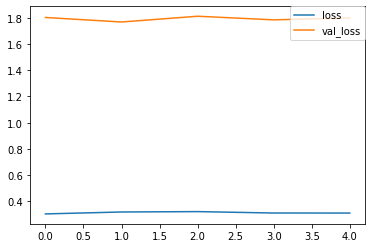

In [12]:
from matplotlib import pyplot as plt
print (hist.history)
plt.figure(1)
plt.plot (hist.history['loss'],label='loss')
plt.plot (hist.history['val_loss'], label='val_loss')
plt.legend(bbox_to_anchor=(1,1),#图例边界框起始位置
                 loc="upper right",#图例的位置
                 ncol=1,#列数
                 mode="None",#当值设置为“expend”时，图例会水平扩展至整个坐标轴区域
                 borderaxespad=0,#坐标轴和图例边界之间的间距
                 shadow=False,#是否为线框添加阴影
                 fancybox=True)#线框圆角处理参数
plt.show()



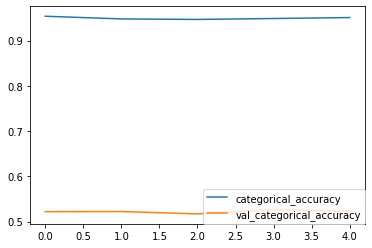

In [13]:
plt.figure(2)
plt.plot (hist.history['categorical_accuracy'], label='categorical_accuracy')
plt.plot (hist.history['val_categorical_accuracy'], label='val_categorical_accuracy')
plt.legend(bbox_to_anchor=(1,0),#图例边界框起始位置
                 loc="lower right",#图例的位置
                 ncol=1,#列数
                 mode="expend",#当值设置为“expend”时，图例会水平扩展至整个坐标轴区域
                 borderaxespad=0,#坐标轴和图例边界之间的间距
                 shadow=False,#是否为线框添加阴影
                 fancybox=True)#线框圆角处理参数
plt.show()